In [1]:
!pip install --upgrade tensorflow==1.14

Requirement already up-to-date: tensorflow==1.14 in /usr/local/lib/python3.6/dist-packages (1.14.0)


In [2]:
import keras.backend as K 
import numpy as np 
from keras.engine.saving import load_model
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
import tensorflow as tf 
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
import os

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from matplotlib.colors import ListedColormap

In [0]:
random_seed = 42
np.random.seed(random_seed)
sess = tf.Session()
K.set_session(sess)

In [0]:
class OCNN:

  def __init__(self, input_features, hidden_layers, r = 1.0):
    self.input_features = input_features
    self.hidden_layers = hidden_layers
    self.r = r 

  def quantile_loss(r, y, nu):
    term1 = 1/nu * K.mean(K.maximum(0.0, r - y), axis = -1)
    #term2 = -1 * r 
    return term1

  def custom_ocnn_loss(self, w, V, nu):

    def custom_hinge(_, y_pred):
      term1 = 0.5 * tf.reduce_sum(w[0]**2)
      term2 = 0.5 * tf.reduce_sum(V[0]**2)
      loss = term1 + term2 + OCNN.quantile_loss(self.r, y_pred, nu)
      self.r = tf.reduce_max(y_pred, axis = 1)
      self.r = tf.contrib.distributions.percentile(self.r, q = 100 * nu)
      return loss
    return custom_hinge

  def build_model(self):
    h_size = self.hidden_layers
    model = Sequential()
    input_hidden = Dense(h_size, input_dim = self.input_features, kernel_initializer = 'glorot_normal', name = 'input_hidden')
    model.add(input_hidden)
    model.add(Activation('linear'))
    hidden_output = Dense(1, name = 'hidden_output')
    model.add(hidden_output)
    model.add(Activation('sigmoid'))

    with sess.as_default():
      w = input_hidden.get_weights()[0]
      V = hidden_output.get_weights()[0]

    return [model, w, V]

  def train_model(self, X, epochs = 100, nu = 1e-2, init_lr = 1e-2, save = True):
    
    def r_metric(*args):
      return self.r 

    r_metric.__name__ = 'r'

    def quantile_loss_metric(*args):
      return OCNN.quantile_loss(self.r, args[1], nu)

    quantile_loss_metric.__name__ = 'quantile_loss'

    [model, w, V] = self.build_model()

    model.compile(optimizer = Adam(lr = init_lr, decay = init_lr/epochs), loss = self.custom_ocnn_loss(w, V, nu),
                  metrics = [r_metric, quantile_loss_metric])

    history = model.fit(X, np.zeros((X.shape[0],)), shuffle = True, batch_size = 250, epochs = epochs, validation_split=0.2)

    if save:
      with sess.as_default():
        w = model.layers[0].get_weights()[0]
        V = model.layers[2].get_weights()[0]

      model.save('ocnn_model.h5')
      np.savez('ocnn_params.npz', w = w, V = V, nu = nu)

    return model, history

In [0]:
num_features = 2
num_hidden = 32
r = 1.0
epochs = 500
nu = 0.001

In [0]:
ocnn = OCNN(num_features, num_hidden, r)

In [10]:
pwd

'/content'

In [11]:
cd drive/My\ Drive/concrete_crack

/content/drive/My Drive/concrete_crack


In [12]:
pwd

'/content/drive/My Drive/concrete_crack'

In [13]:
cd encoded_decoded_data_64/

/content/drive/My Drive/concrete_crack/encoded_decoded_data_64


In [0]:
X_val_balanced = np.load('enc3_b_64.npy', allow_pickle=True)
X_val_imbalanced = np.load('enc3_i_64.npy', allow_pickle=True)

In [15]:
cd ..

/content/drive/My Drive/concrete_crack


In [16]:
cd data_64/

/content/drive/My Drive/concrete_crack/data_64


In [0]:
X_train = np.load('X_train_encoded.npy', allow_pickle=True)

In [18]:
cd ..

/content/drive/My Drive/concrete_crack


In [19]:
cd ocnn_models/

/content/drive/My Drive/concrete_crack/ocnn_models


In [165]:
model, history = ocnn.train_model(X_train, epochs = epochs, nu = nu)

Train on 12800 samples, validate on 3200 samples
Epoch 1/500
12800/12800 [==============================] - 0s 23us/step - loss: 138.9847 - r: 1.0000 - quantile_loss: 137.9432 - val_loss: 3.2435 - val_r: 1.0000 - val_quantile_loss: 2.2020
Epoch 2/500
12800/12800 [==============================] - 0s 7us/step - loss: 2.2038 - r: 1.0000 - quantile_loss: 1.1623 - val_loss: 1.7711 - val_r: 1.0000 - val_quantile_loss: 0.7296
Epoch 3/500
12800/12800 [==============================] - 0s 8us/step - loss: 1.6221 - r: 1.0000 - quantile_loss: 0.5806 - val_loss: 1.4938 - val_r: 1.0000 - val_quantile_loss: 0.4523
Epoch 4/500
12800/12800 [==============================] - 0s 6us/step - loss: 1.4180 - r: 1.0000 - quantile_loss: 0.3765 - val_loss: 1.3487 - val_r: 1.0000 - val_quantile_loss: 0.3072
Epoch 5/500
12800/12800 [==============================] - 0s 7us/step - loss: 1.3049 - r: 1.0000 - quantile_loss: 0.2634 - val_loss: 1.2636 - val_r: 1.0000 - val_quantile_loss: 0.2221
Epoch 6/500
12800/128

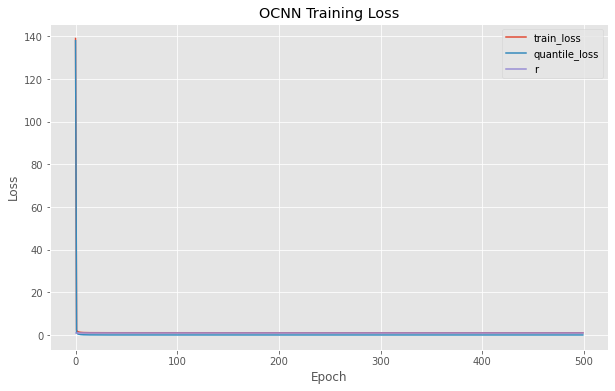

In [166]:
plt.style.use("ggplot")
plt.figure(figsize=(10,6))
plt.plot(history.epoch, history.history["loss"], label="train_loss")
plt.plot(history.epoch, history.history["quantile_loss"], label="quantile_loss")
plt.plot(history.epoch, history.history["r"], label="r")
plt.title("OCNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

# Predicting Balanced Dataset

In [0]:
y_pred_balanced = model.predict(X_val_balanced)

In [0]:
r = history.history['r'].pop()

In [169]:
r

1.0

In [0]:
s_n = [y_pred_balanced[i, 0] - r >= 0 for i in range(len(y_pred_balanced))]

In [0]:
frac_of_outliers = len([s for s in s_n if s == 0]) / len(s_n)

In [0]:
cmap = ListedColormap(['r', 'b'])

In [0]:
feature_index_to_name = {0: "Encoded Feature 1",
                             1: "Encoded Feature 2"}

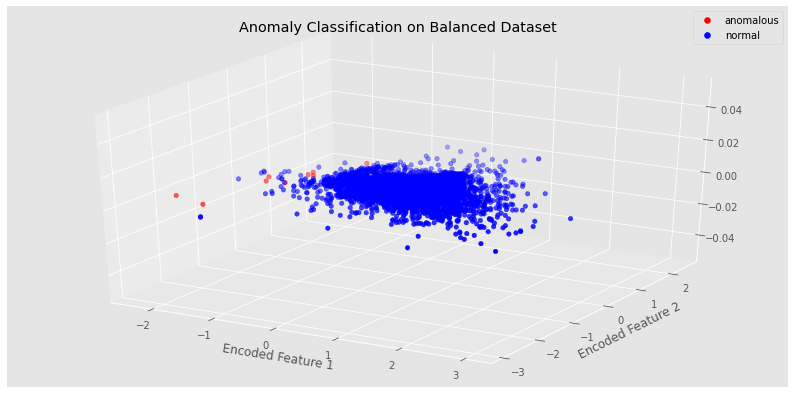

In [174]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_val_balanced[:, 0], X_val_balanced[:, 1], c=s_n, cmap=cmap)
ax.set_xlabel(feature_index_to_name[0])
ax.set_ylabel(feature_index_to_name[1])
#ax.set_zlabel(feature_index_to_name[2])
plt.legend(handles=scatter.legend_elements()[0], labels=['anomalous', 'normal'], loc='upper right')
plt.title('Anomaly Classification on Balanced Dataset')
plt.show()

In [175]:
frac_of_outliers

0.001125

In [0]:
s_n = np.array(s_n)

In [177]:
len(np.where(s_n == False)[0])

9

# Predicting Imbalanced Dataset

In [0]:
y_pred_imbalanced = model.predict(X_val_imbalanced)

In [0]:
s_n = [y_pred_imbalanced[i, 0] - r >= 0 for i in range(len(y_pred_imbalanced))]

In [0]:
frac_of_outliers = len([s for s in s_n if s == 0]) / len(s_n)

In [0]:
cmap = ListedColormap(['r', 'b'])

In [0]:
feature_index_to_name = {0: "Encoded Feature 1",
                             1: "Encoded Feature 2"}

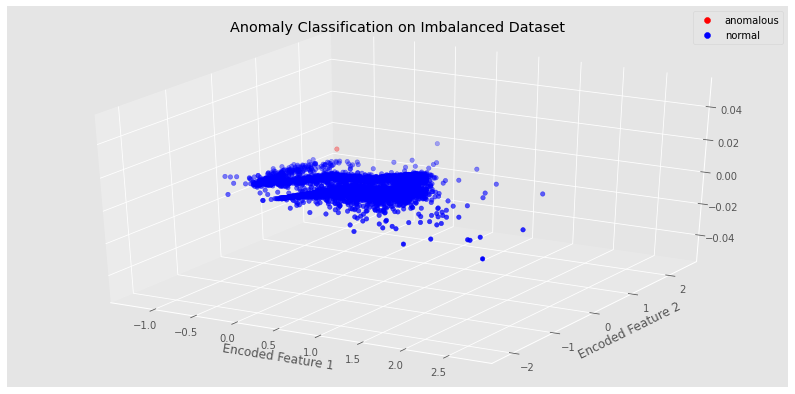

In [183]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_val_imbalanced[:, 0], X_val_imbalanced[:, 1], c=s_n, cmap=cmap)
ax.set_xlabel(feature_index_to_name[0])
ax.set_ylabel(feature_index_to_name[1])
#ax.set_zlabel(feature_index_to_name[2])
plt.legend(handles=scatter.legend_elements()[0], labels=['anomalous', 'normal'], loc='upper right')
plt.title('Anomaly Classification on Imbalanced Dataset')
plt.show()

In [184]:
frac_of_outliers

0.00022222222222222223

In [0]:
s_n = np.array(s_n)

In [186]:
len(np.where(s_n == False)[0])

1